In [1]:
import pandas as pd

# Charger les données depuis un fichier CSV 
df = pd.read_csv("AMZN.csv")

# Afficher les premières lignes du dataframe
print(df.head(10))


         Date       Open       High        Low      Close  Adj Close  \
0  2019-01-25  83.525002  84.174004  83.080498  83.528503  83.528503   
1  2019-01-28  82.179497  82.250000  80.704498  81.894501  81.894501   
2  2019-01-29  81.563499  81.619003  79.536003  79.694000  79.694000   
3  2019-01-30  81.150002  83.847504  80.984001  83.521500  83.521500   
4  2019-01-31  84.642502  86.820503  83.954002  85.936501  85.936501   
5  2019-02-01  81.944000  83.653000  81.100502  81.311501  81.311501   
6  2019-02-04  81.150002  82.481499  80.675003  81.665497  81.665497   
7  2019-02-05  82.167000  83.263000  82.125000  82.940498  82.940498   
8  2019-02-06  83.537498  83.612999  81.667000  82.013000  82.013000   
9  2019-02-07  81.250000  81.277000  79.645500  80.718498  80.718498   

      Volume  
0   98918000  
1   96754000  
2   92656000  
3  115676000  
4  218206000  
5  230124000  
6   98582000  
7   89062000  
8   78798000  
9   92532000  


In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Supposons que vous avez plusieurs séquences temporelles dans df, chaque séquence dans une colonne différente
data = pd.DataFrame(df)

# Normalisation des données pour chaque colonne
scaler = MinMaxScaler()
data_normalized = pd.DataFrame({'Close': scaler.fit_transform(data['Close'].values.reshape(-1, 1)).flatten()})

# Création de séquences temporelles
def create_sequences(dat, seq_length):
    sequences = []
    for i in range(len(dat) - seq_length + 1):
        X = dat.iloc[i:i+seq_length-1, :]  # Les caractéristiques (X) sont les valeurs dans la séquence à l'exception de la dernière
        y = dat.iloc[i+seq_length-1, :]    # L'étiquette (y) est la dernière valeur de la séquence
        sequences.append((X, y))
    return sequences

# Définir la longueur de la séquence temporelle
seq_length = 10

# Créer des séquences temporelles
sequences = create_sequences(data_normalized, seq_length)

# Diviser les données en ensembles d'entraînement, de validation et de test
train_size = int(len(sequences) * 0.8)
train, test = sequences[:train_size], sequences[train_size:]

# Diviser les séquences en caractéristiques (X) et étiquettes (y)
X_train, y_train = np.array([seq[0] for seq in train]), np.array([seq[1] for seq in train])
X_test, y_test = np.array([seq[0] for seq in test]), np.array([seq[1] for seq in test])

# Diviser les ensembles d'entraînement en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# Afficher la taille actuelle des données
print("Taille de X_train :", X_train.shape)
print("Taille de X_val   :", X_val.shape)




Taille de X_train : (799, 9, 1)
Taille de X_val   : (200, 9, 1)


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(seq_length-1, 1)))  #  seq_length-1 pour correspondre à la longueur des séquences
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# Reshape des données pour l'entrée du modèle LSTM
X_train = X_train.reshape(-1, seq_length-1, 1)  #  seq_length-1 pour correspondre à la longueur des séquences
X_val = X_val.reshape(-1, seq_length-1, 1)

# Entraînement du modèle
model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

# Afficher le résumé du modèle
model.summary()

Epoch 1/5
25/25 [==============================] - 3s 27ms/step - loss: 0.2981 - val_loss: 0.1450
Epoch 2/5
25/25 [==============================] - 0s 8ms/step - loss: 0.0453 - val_loss: 0.0126
Epoch 3/5
25/25 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0058
Epoch 4/5
25/25 [==============================] - 0s 9ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 5/5
25/25 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0031
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 By

In [4]:
predictions = model.predict(X_test)


8/8 [==============================] - 0s 3ms/step


In [5]:
predictions = scaler.inverse_transform(predictions)


In [7]:
compare_df = pd.DataFrame({'Actual': scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(),
                           'Predicted': predictions.flatten()})
print(compare_df)

         Actual   Predicted
0     99.220001   96.246689
1    102.239998   96.729759
2    100.550003   97.510132
3    103.129997   98.111168
4    105.150002   99.053635
..          ...         ...
245  153.500000  150.279663
246  155.339996  150.788086
247  154.779999  151.545883
248  156.020004  152.035172
249  156.869995  152.646454

[250 rows x 2 columns]


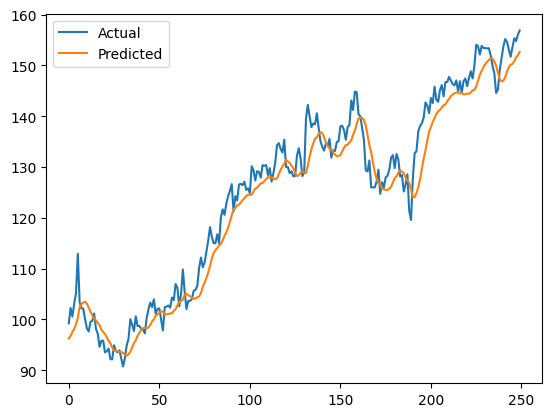

In [8]:
import matplotlib.pyplot as plt

plt.plot(compare_df['Actual'], label='Actual')
plt.plot(compare_df['Predicted'], label='Predicted')
plt.legend()
plt.show()


In [9]:
# Enregistrement du modèle
model.save('time_series_model.h5')


C:\Users\Utilisateur\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
